# Calibrated Explanations for Regression
## Demonstrated on the California Housing data set

Author: Tuwe Löfström (tuwe.lofstrom@ju.se)  
Copyright 2023 Tuwe Löfström  
License: BSD 3 clause
Sources:
1. [California Housing data set [kaggle]](https://www.kaggle.com/datasets/camnugent/california-housing-prices)
2. [Löfström, T](https://github.com/tuvelofstrom)., [Löfström, H](https://github.com/Moffran)., Johansson, U., Sönströd, C., and [Matela, R](https://github.com/rudymatela). [Calibrated Explanations for Regression](https://arxiv.org/abs/2308.16245). arXiv preprint arXiv:2308.16245.

### 1. Import packages, data and train an underlying model

#### 1.1 Import packages

In the examples below, we will be using `NumPy`, `pandas`, `sklearn`, and `crepes`. From `crepes`, we import `ConformalPredictiveSystem` and some helper functions from `crepes.extras`. `CalibratedExplainer` is imported from `calibrated_explanations`.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from calibrated_explanations import CalibratedExplainer, __version__

from crepes import ConformalPredictiveSystem
from crepes.extras import DifficultyEstimator 

print(f"calibrated_explanations {__version__}")

calibrated_explanations v0.3.5


#### 1.2 Import data and train a model
Let us import the California Housing data set (see sources at the top).

In [3]:

dataSet = 'housing.csv'
delimiter = ';'
categorical_labels = {8: {0: 'INLAND', 1: 'NEAR BAY', 2: '<1H OCEAN', 3: 'NEAR OCEAN', 4: 'ISLAND'}}

fileName = '../data/reg/' + dataSet
df = pd.read_csv(fileName, delimiter=delimiter, dtype=np.float64)
target = 'median_house_value'
df.dropna(inplace=True)
X, y = df.drop(target,axis=1), df[target] 
feature_names = df.drop(target,axis=1).columns
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,1.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,1.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,1.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,1.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,1.0


Let us split the data set into a training and a test set, and further split the training set into a proper training set and a calibration set. Let us fit a random forest to the proper training set. We also set a random seed to be able to rerun the notebook and get the same results.

In [4]:
num_to_test = 2

trainCalX, testX, trainCalY, testY = train_test_split(X.values, y.values, test_size=num_to_test, random_state=42)
trainX, calX, trainY, calY = train_test_split(trainCalX, trainCalY, test_size=1000, random_state=42)

model = RandomForestRegressor(n_estimators=100, oob_score=True)

model.fit(trainX,trainY)  

RandomForestRegressor(oob_score=True)

Before extracting an explanation, lets see what the output from a Conformal Predictive System (cps) is for the test instances. Three use cases are explored:
1. using percentiles to get the lower and upper bounds of an interval.
2. using the 50th percentile(s) to get the median prediction which can be used as a calibrated prediction from the underlying model.
3. getting the probability of the prediction being below a certain threshold. 250 000 is used as threshold, as it is close to the midpoint in the possible range of prices.

In [5]:
calY_pred = model.predict(calX)
testY_pred = model.predict(testX)

cps = ConformalPredictiveSystem()
cps.fit(residuals=calY-calY_pred)

interval = cps.predict(y_hat=testY_pred, lower_percentiles=[5,50], higher_percentiles=[95,50])

p_values = cps.predict(y_hat=testY_pred, y=180000)

print('5th percentile, prediction, 50th percentile, 95th percentile, true value, p-value (cpsd<180000)')
print(*zip(np.round(interval[:,0], decimals=1), 
           np.round(testY_pred, decimals=1), 
           np.round((interval[:,1] + interval[:,3])/2, decimals=1), 
           np.round(interval[:,2], decimals=1), 
           np.round(testY,decimals=1), 
           np.round(p_values*100, decimals=1)),sep='\n')  

5th percentile, prediction, 50th percentile, 95th percentile, true value, p-value (cpsd<180000)
(148490.0, 217707.0, 214195.5, 291002.0, 245800.0, 12.8)
(94593.0, 163810.0, 160298.5, 237105.0, 137900.0, 76.6)


In [6]:
ce = CalibratedExplainer(model, 
                        calX, 
                        calY, 
                        feature_names=feature_names, 
                        categorical_labels=categorical_labels,
                        mode='regression')  
display(ce)

CalibratedExplainer(mode=regression, model=RandomForestRegressor(oob_score=True), difficulty_estimator=None)

In [7]:
factual_explanation = ce.explain_factual(testX, 180000)

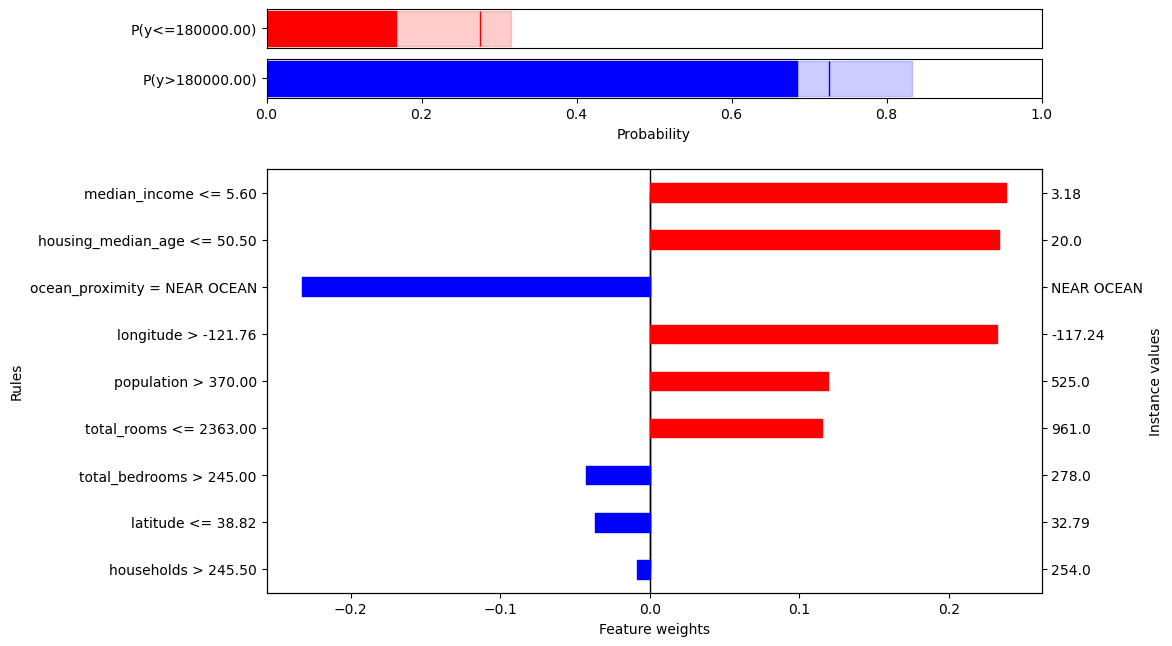

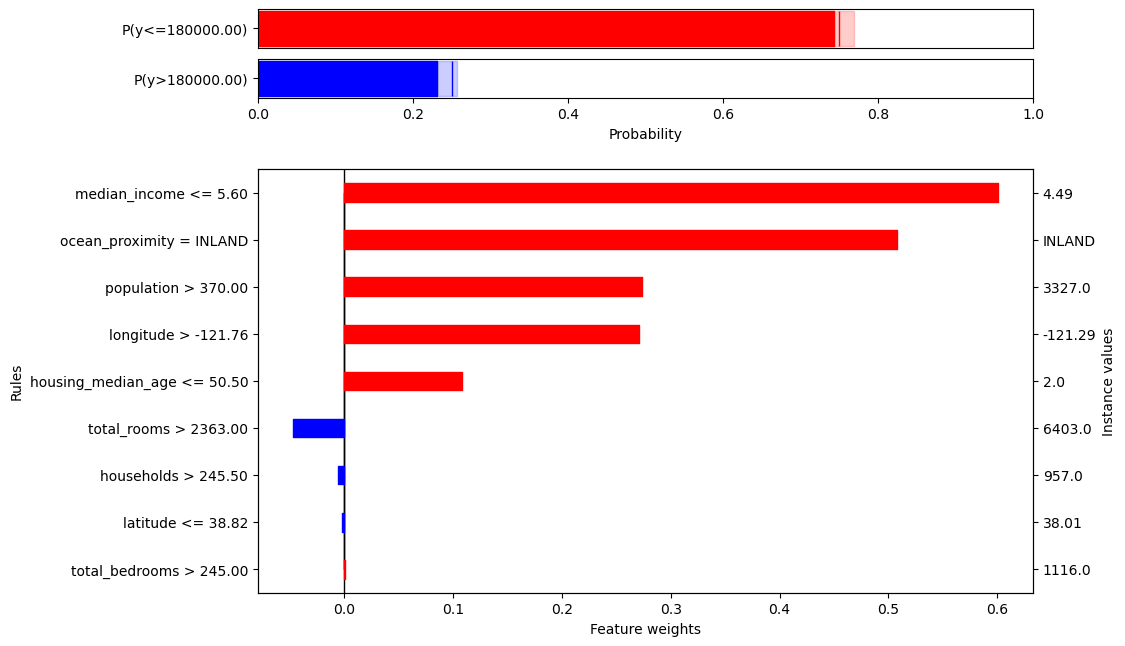

In [8]:
factual_explanation.plot()

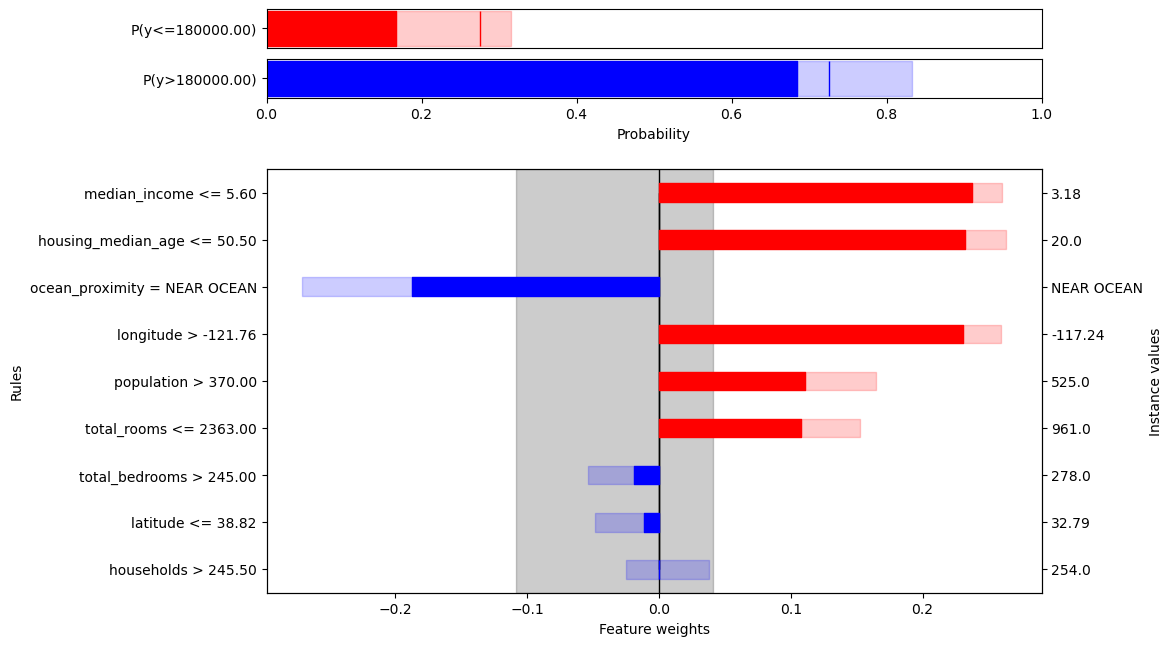

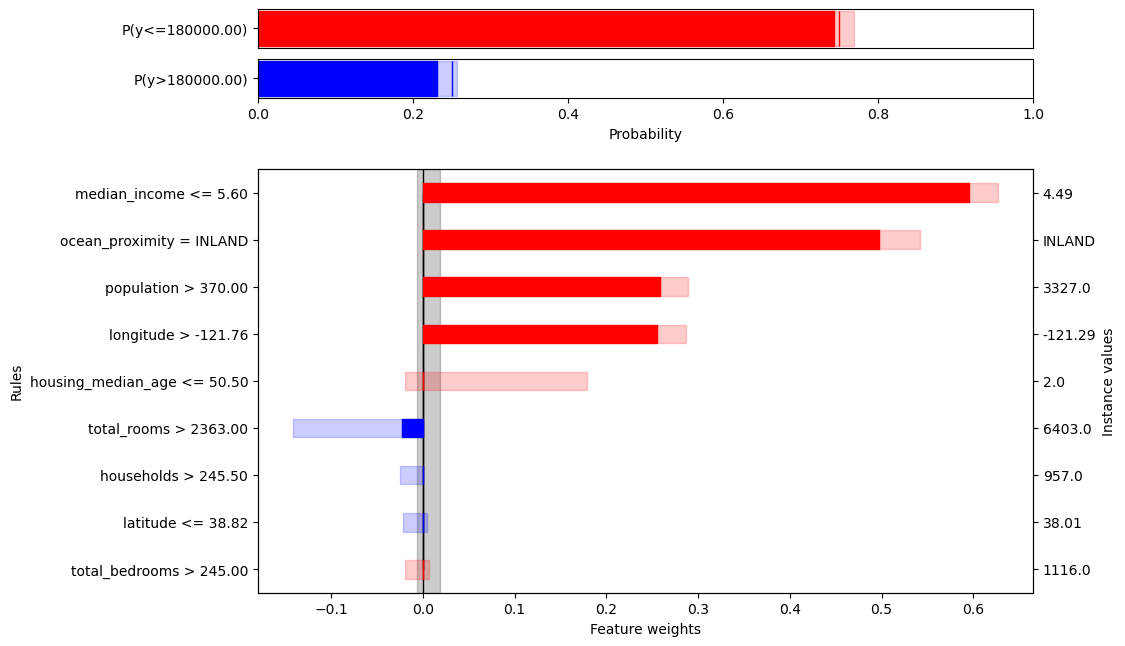

In [9]:
factual_explanation.plot(uncertainty=True)

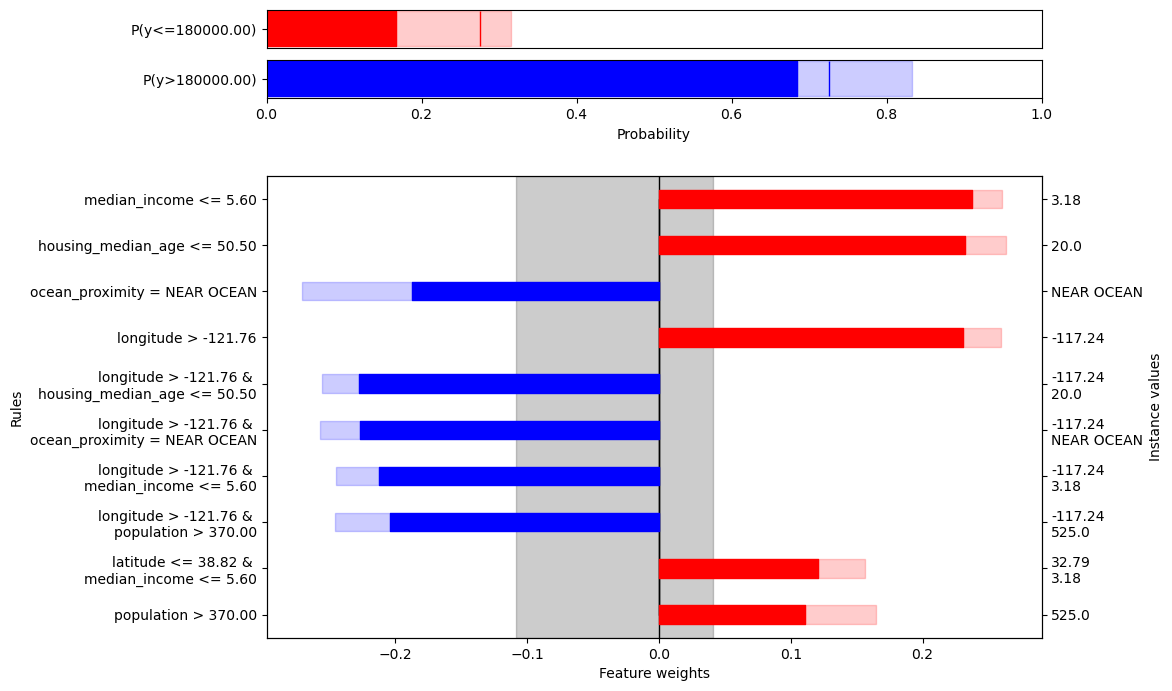

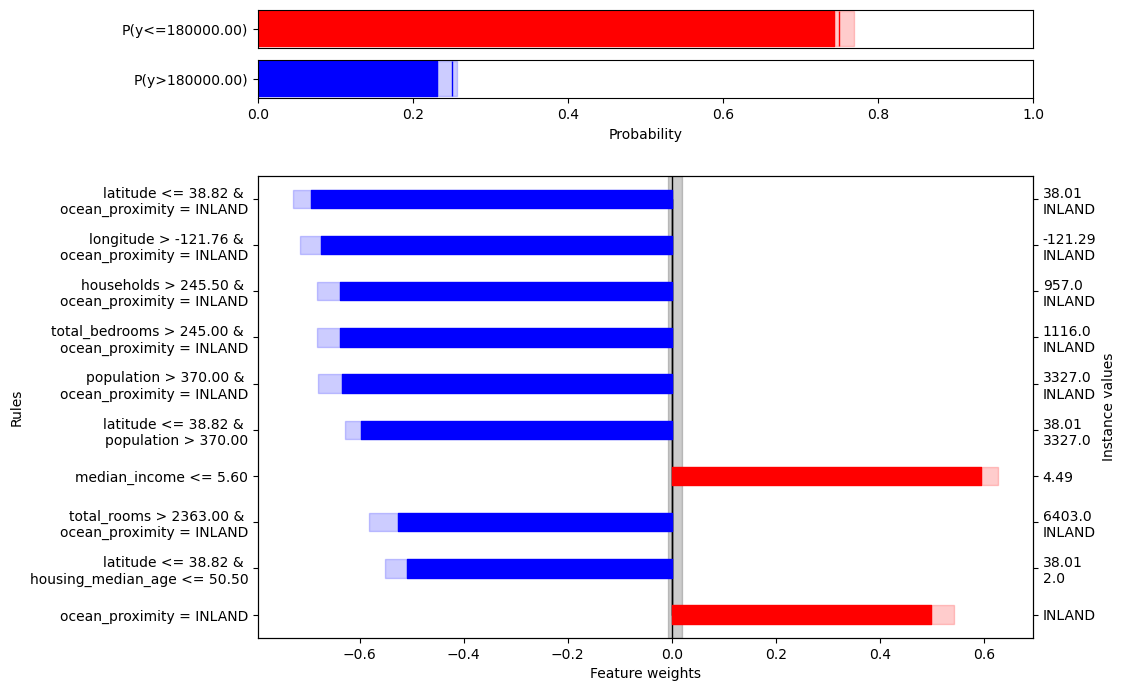

In [10]:
factual_explanation.add_conjunctions().plot(uncertainty=True)

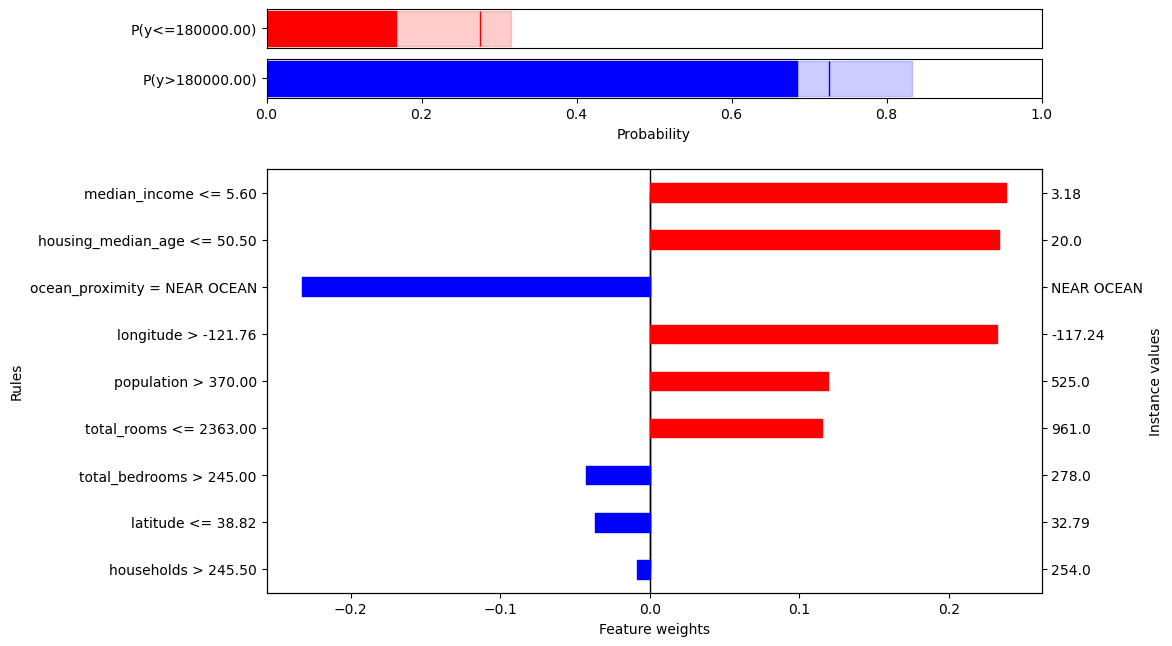

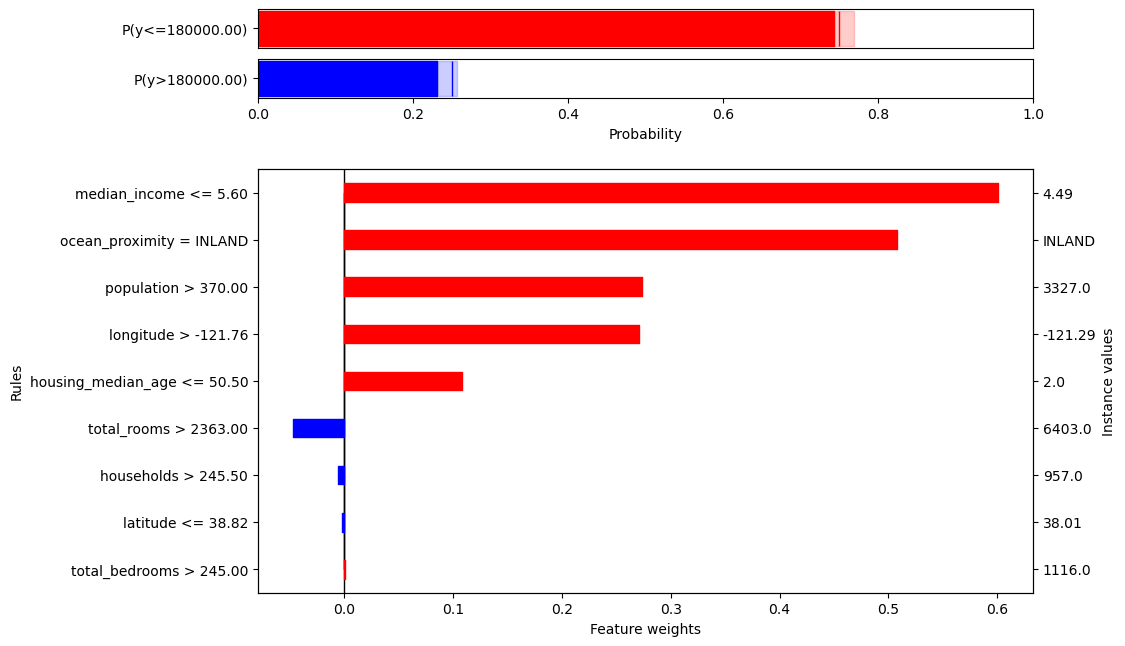

In [11]:
factual_explanation.remove_conjunctions().plot()

In [12]:
counterfactual_explanation = ce.explain_counterfactual(testX, 180000)

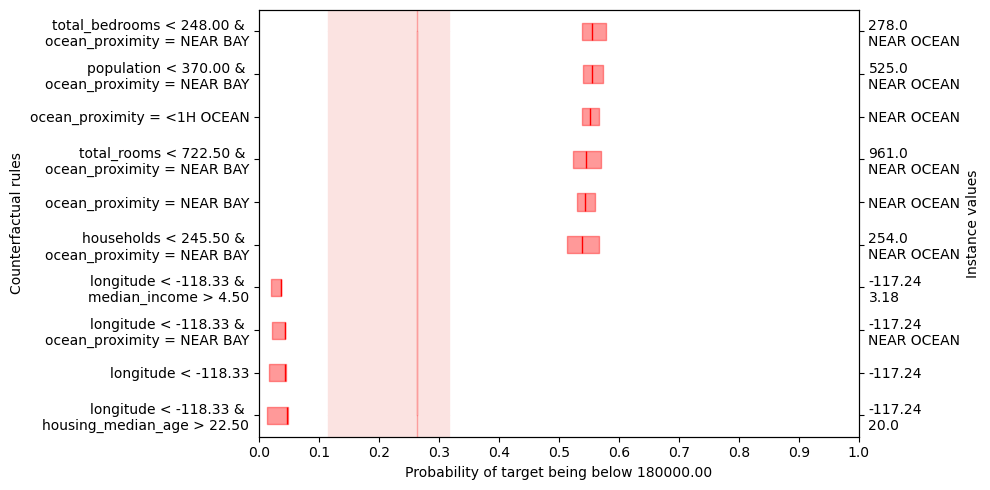

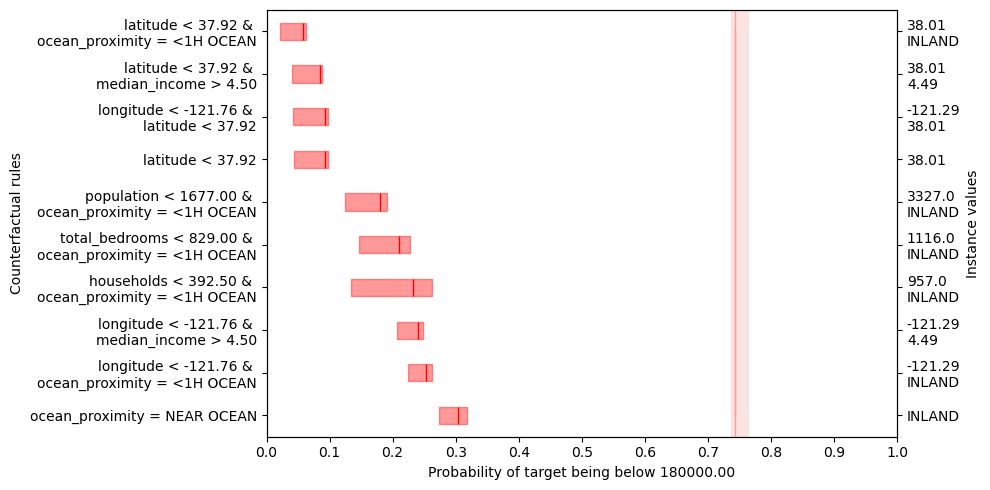

In [13]:
counterfactual_explanation.add_conjunctions().plot()

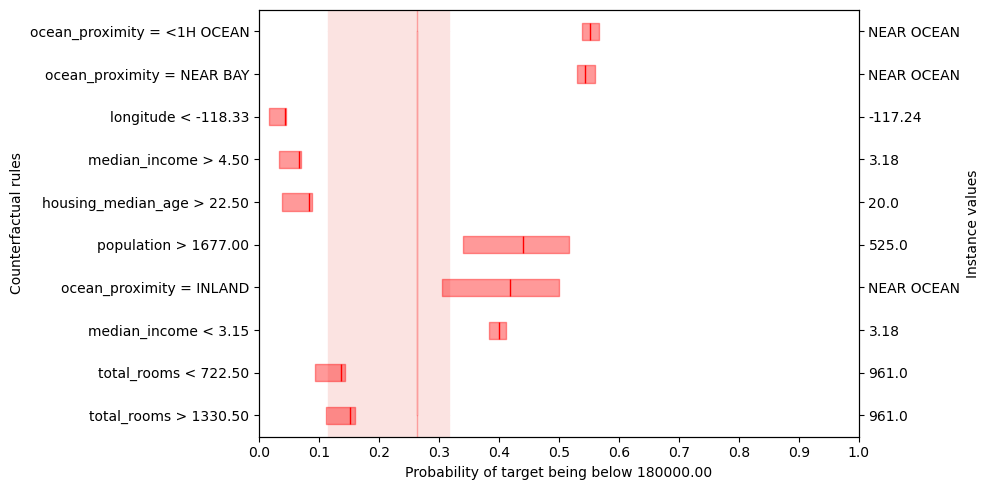

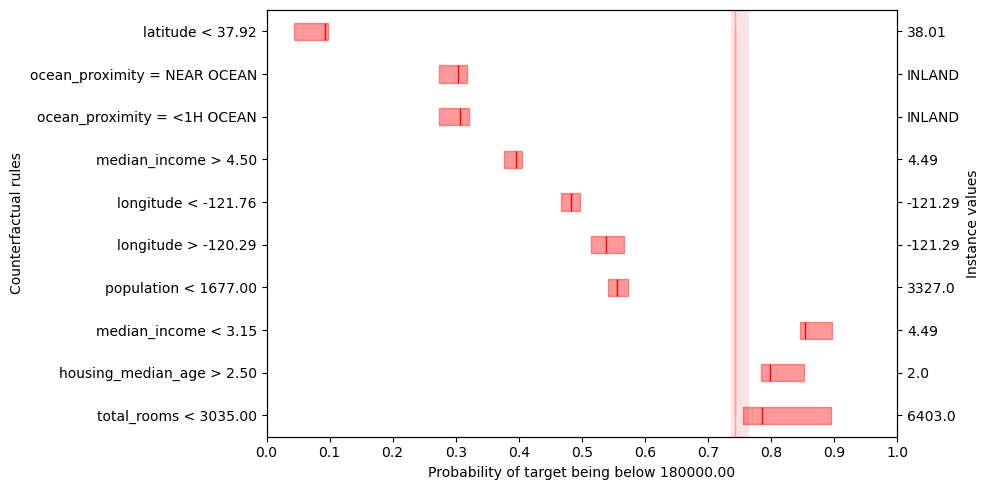

In [14]:
counterfactual_explanation.remove_conjunctions().plot()

#### Normalized explanations using knn

There are three ways to set the difficulty estimator (sigma) for the CalibratedExplainer when using k-nearest neighbor.
* alternative 1: by the (Euclidean) distances to the nearest neighbors
* alternative 2: by the standard deviation of the targets of the nearest neighbors
* alternative 3: by the absolute errors of the k nearest neighbors

See the documentation of crepes for further details, see [here](https://crepes.readthedocs.io/en/latest/).

In [15]:
# alternative 1: by the (Euclidean) distances to the nearest neighbors
ce.set_difficulty_estimator(DifficultyEstimator().fit(X=trainX, scaler=True))

# alternative 2: by the standard deviation of the targets of the nearest neighbors
ce.set_difficulty_estimator(DifficultyEstimator().fit(X=trainX, y=trainY, scaler=True))

# alternative 3: by the absolute errors of the k nearest neighbors
oob_predictions = model.oob_prediction_ # requires the model to have been trained with oob_score=True, available for RandomForestRegressor
residuals_oob = trainY - oob_predictions
ce.set_difficulty_estimator(DifficultyEstimator().fit(X=trainX, residuals=residuals_oob, scaler=True))

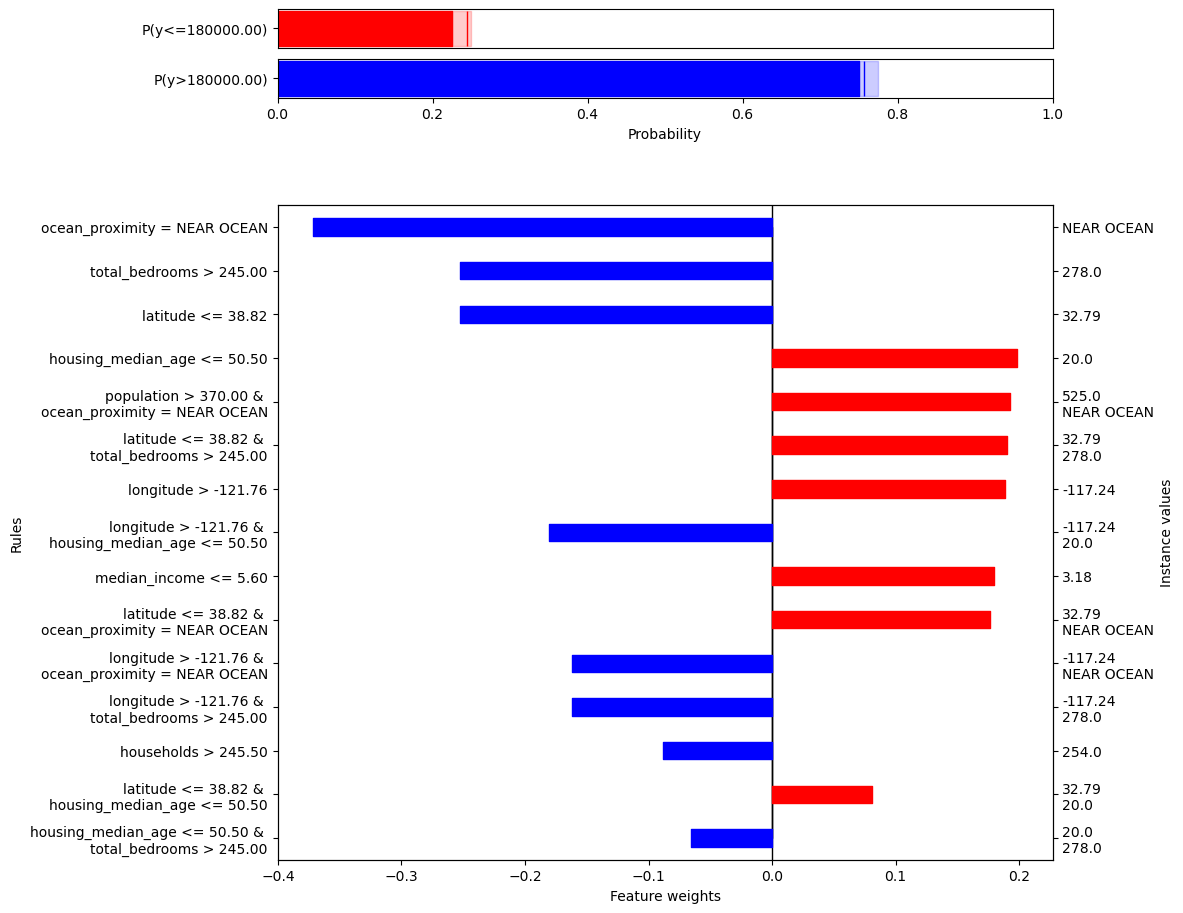

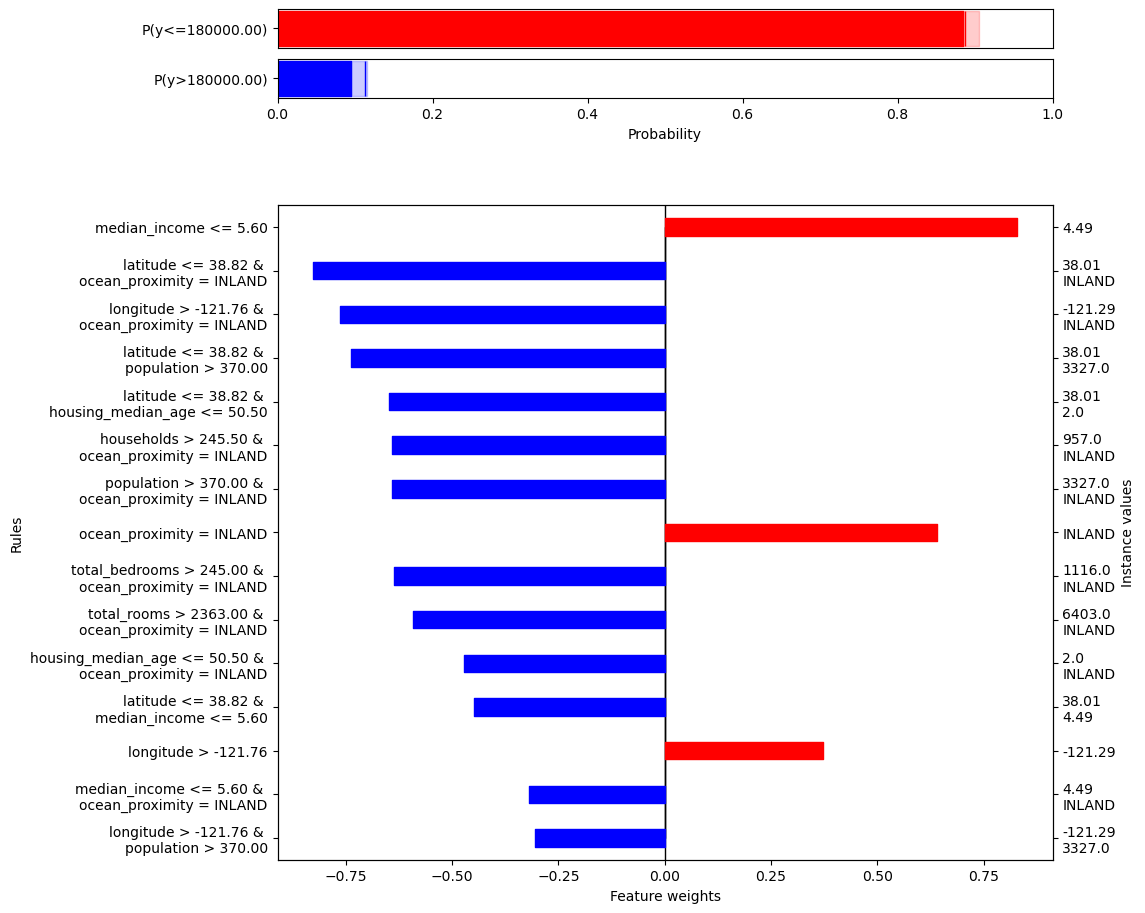

In [16]:
factual_explanation = ce.explain_factual(testX, 180000)

factual_explanation.add_conjunctions(n_top_features=5).plot(n_features_to_show=15)

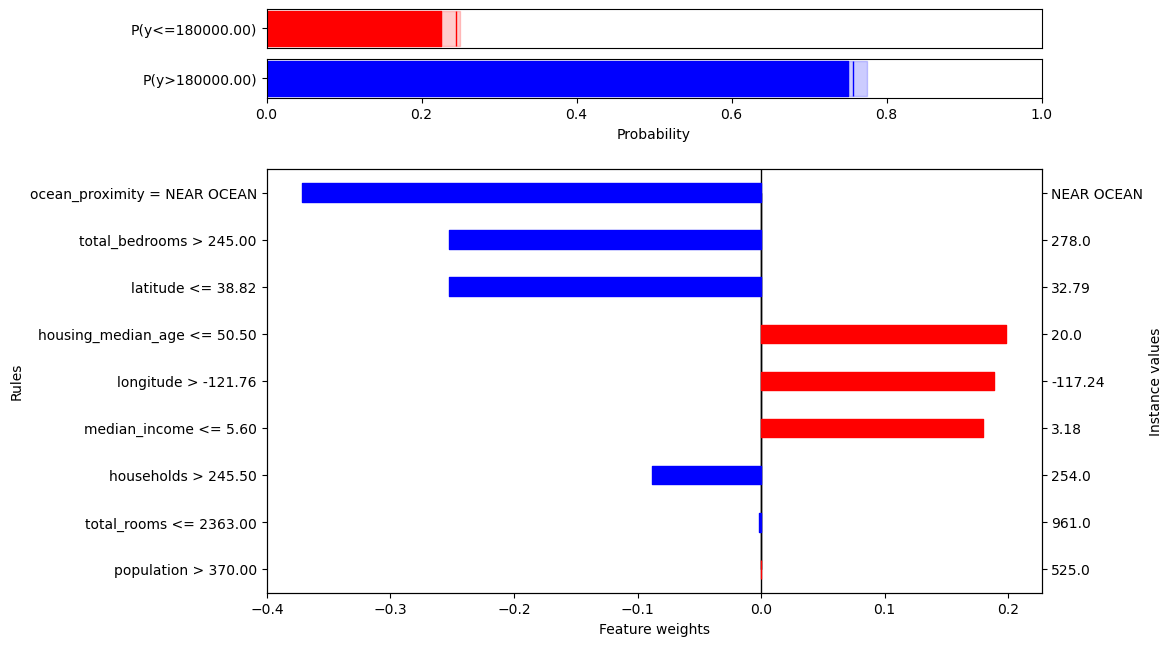

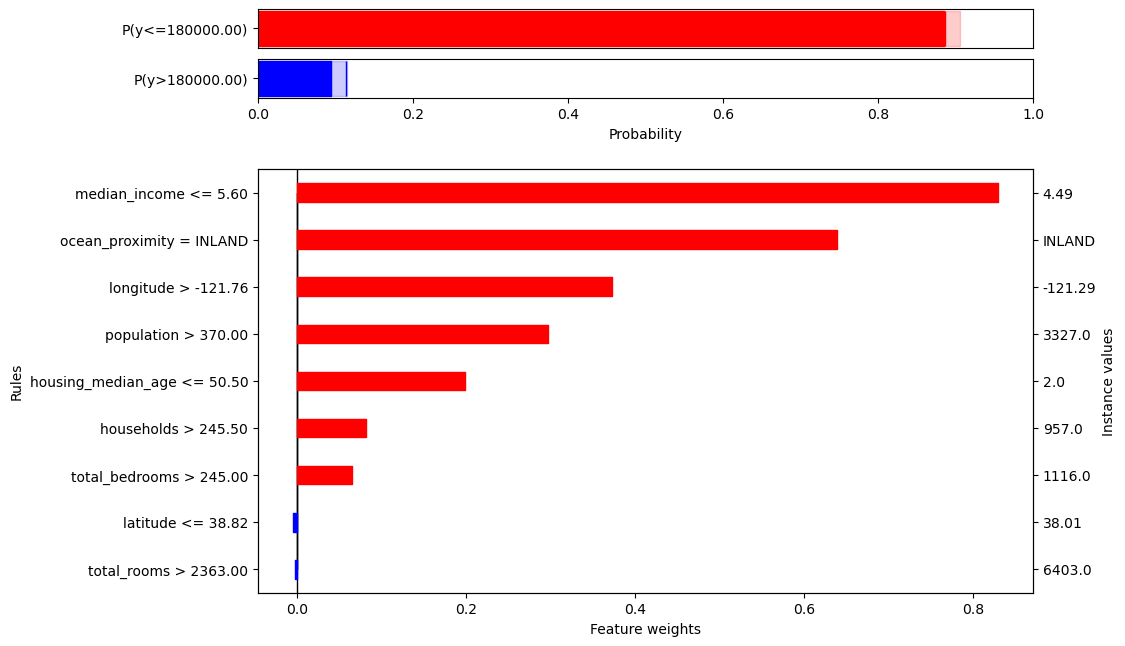

In [17]:
factual_explanation.remove_conjunctions().plot()

#### Normalized counterfactuals using knn

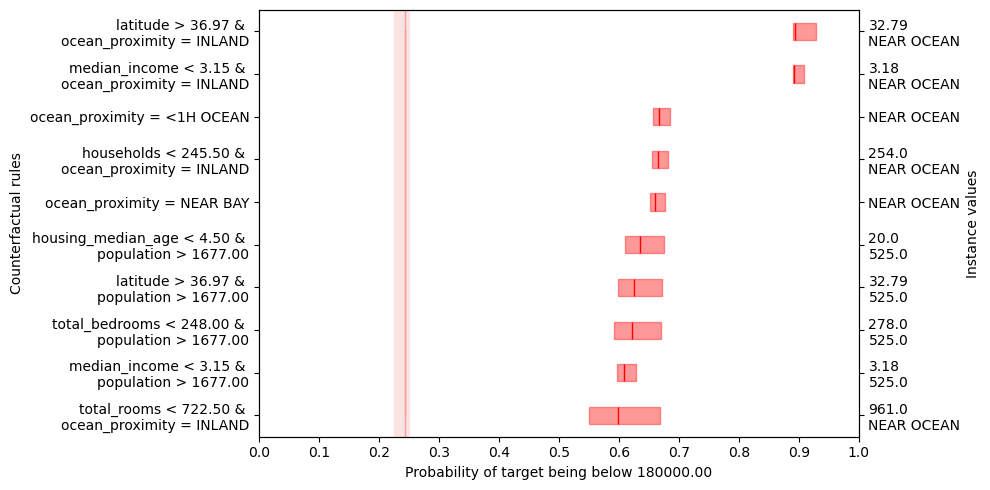

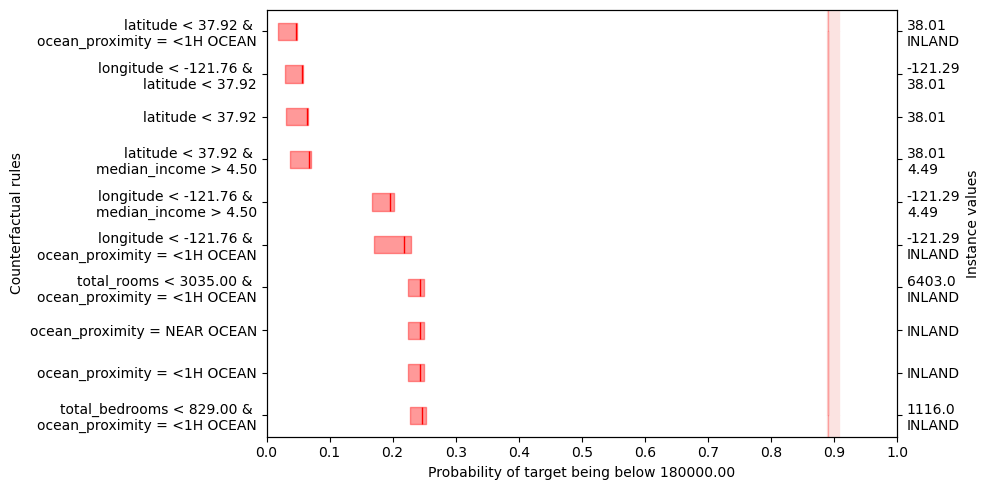

In [18]:
counterfactual_explanation = ce.explain_counterfactual(testX, 180000)

counterfactual_explanation.add_conjunctions().plot()

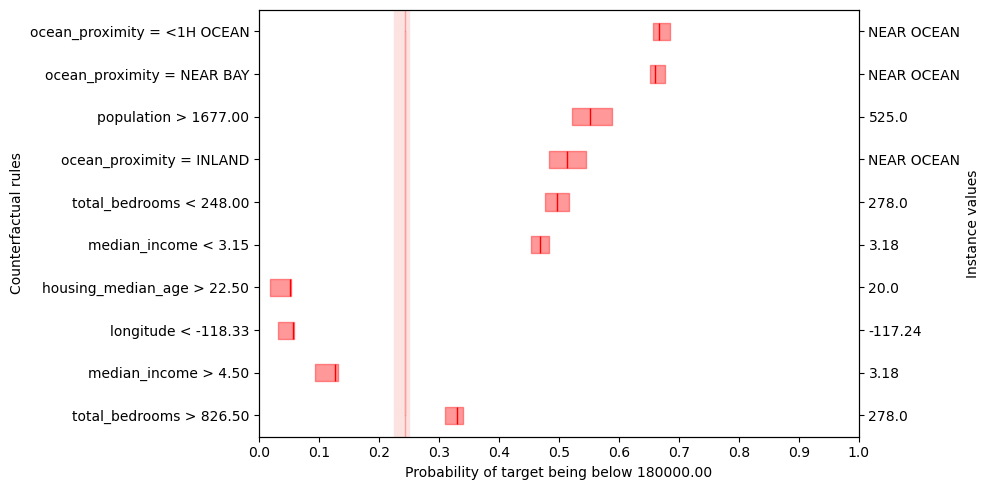

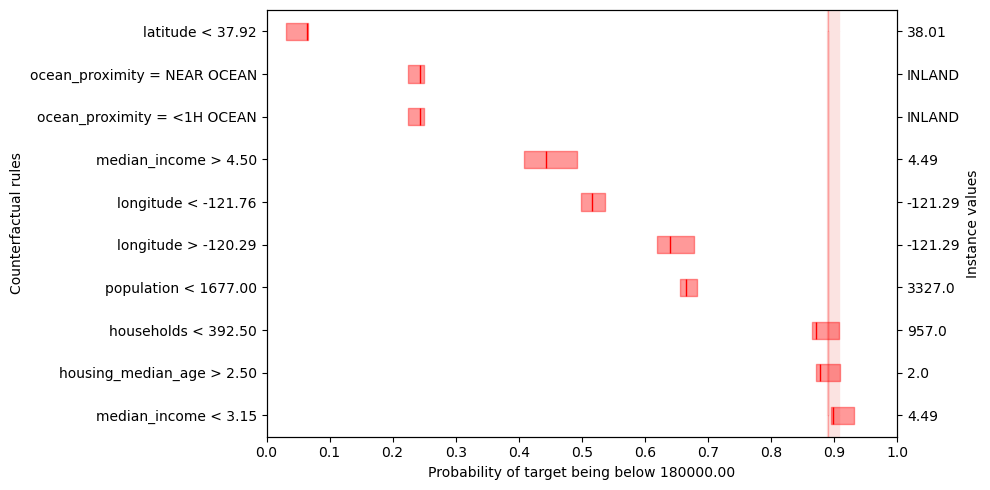

In [19]:
counterfactual_explanation.remove_conjunctions().plot()

#### Normalized explanations using variance

In [20]:
ce.set_difficulty_estimator(DifficultyEstimator().fit(X=trainX, learner=model, scaler=True))

In [21]:
factual_explanation = ce.explain_factual(testX, 180000)

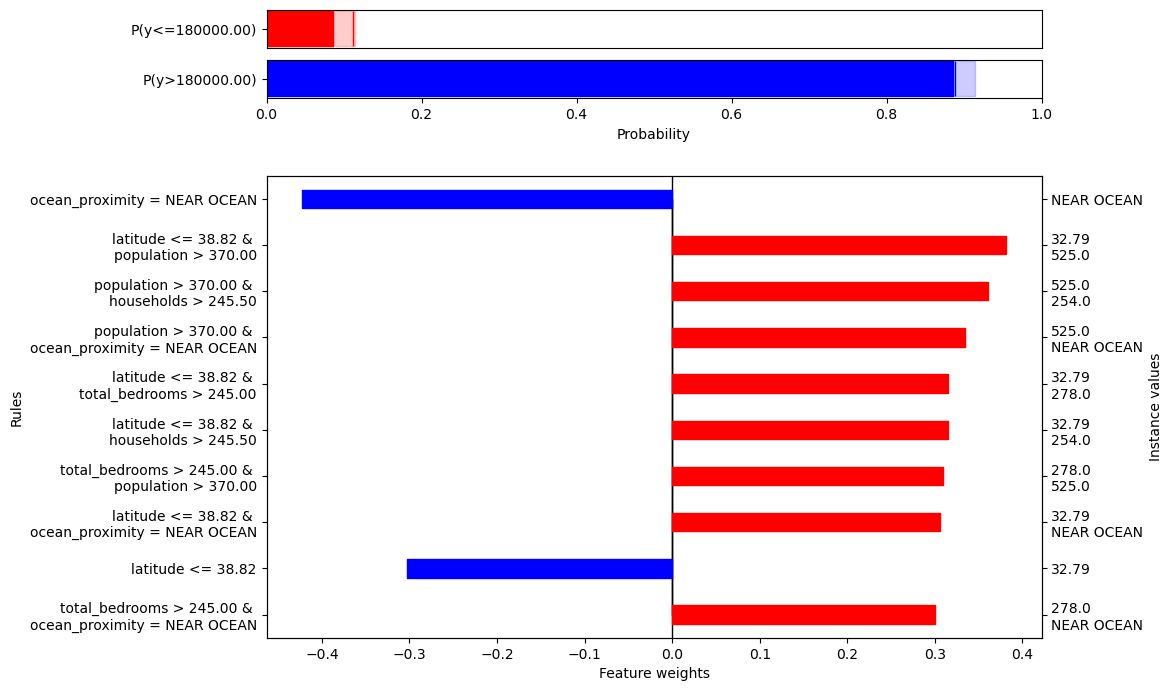

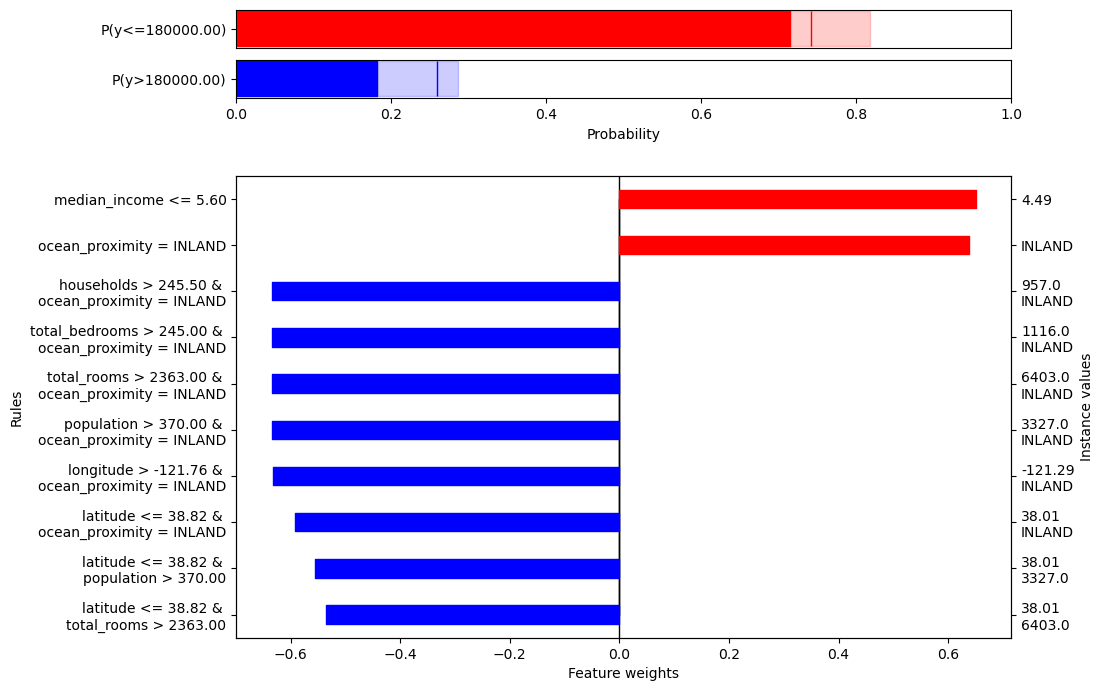

In [22]:
factual_explanation.add_conjunctions().plot()

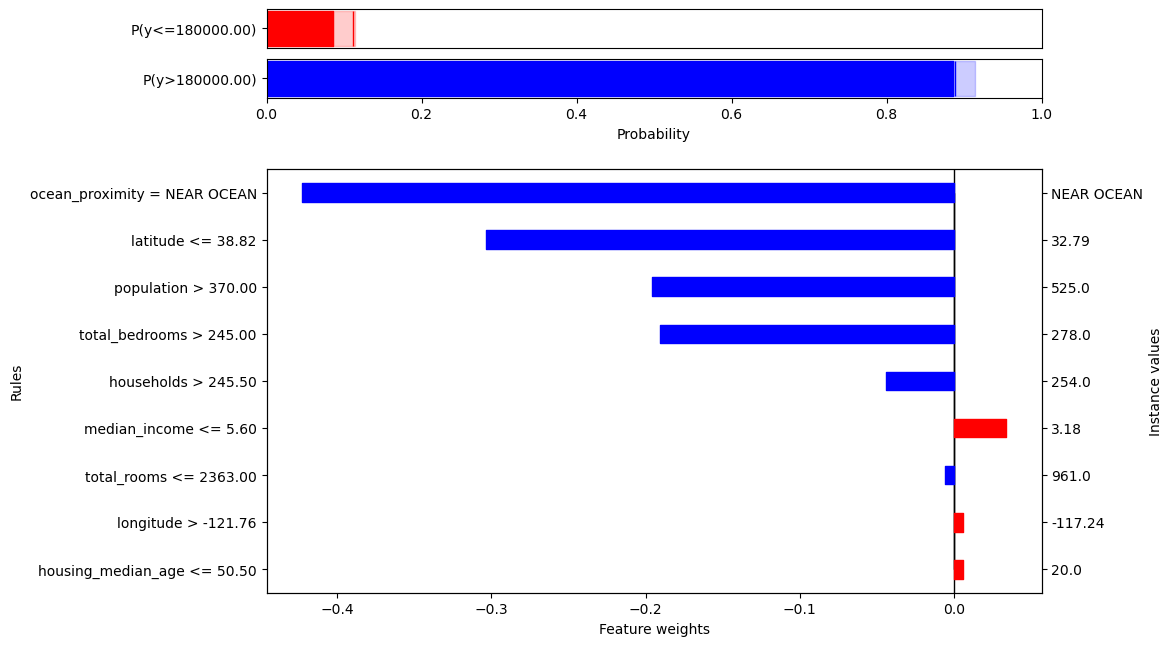

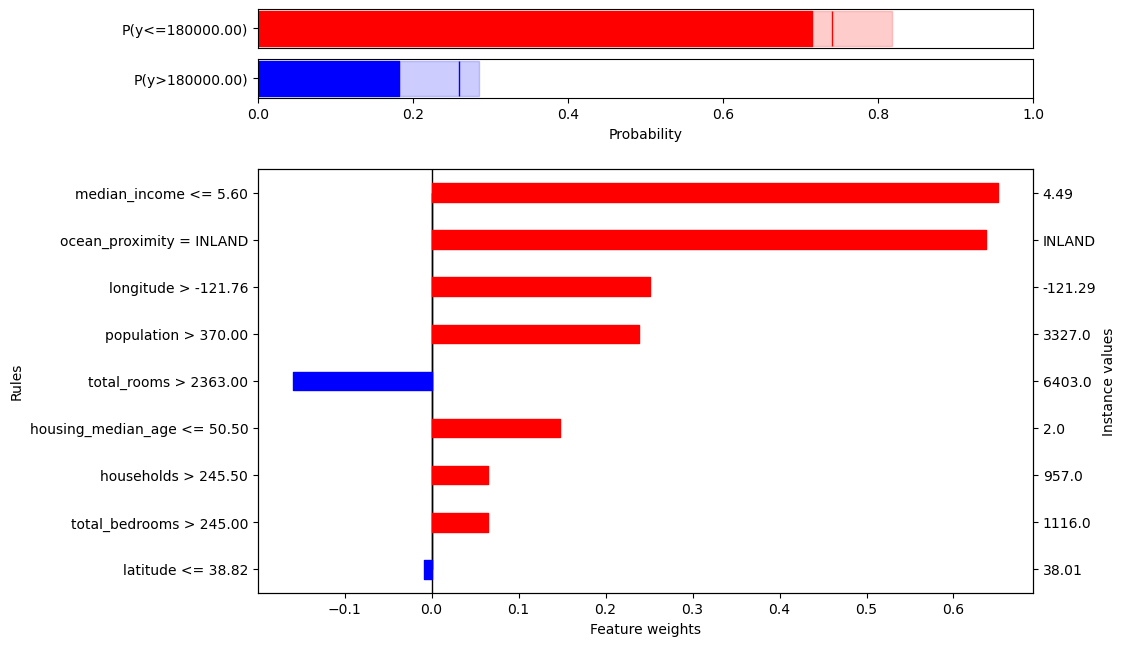

In [23]:
factual_explanation.remove_conjunctions().plot()

#### Normalized counterfactuals using variance

In [24]:
counterfactual_explanation = ce.explain_counterfactual(testX, 180000)

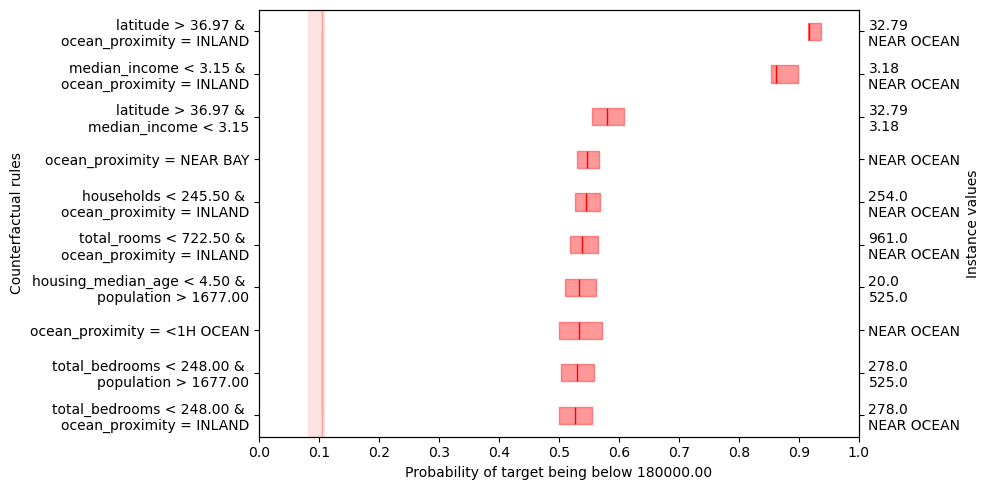

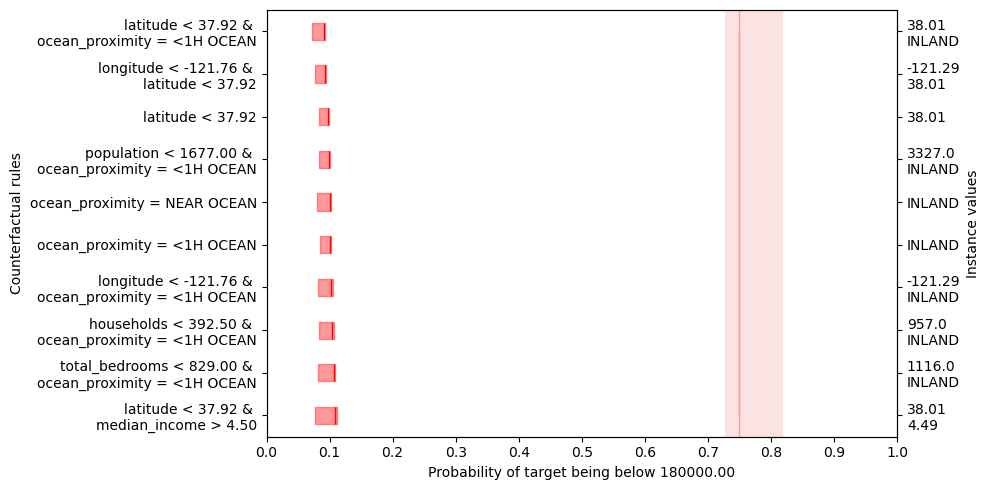

In [25]:
counterfactual_explanation.add_conjunctions().plot()

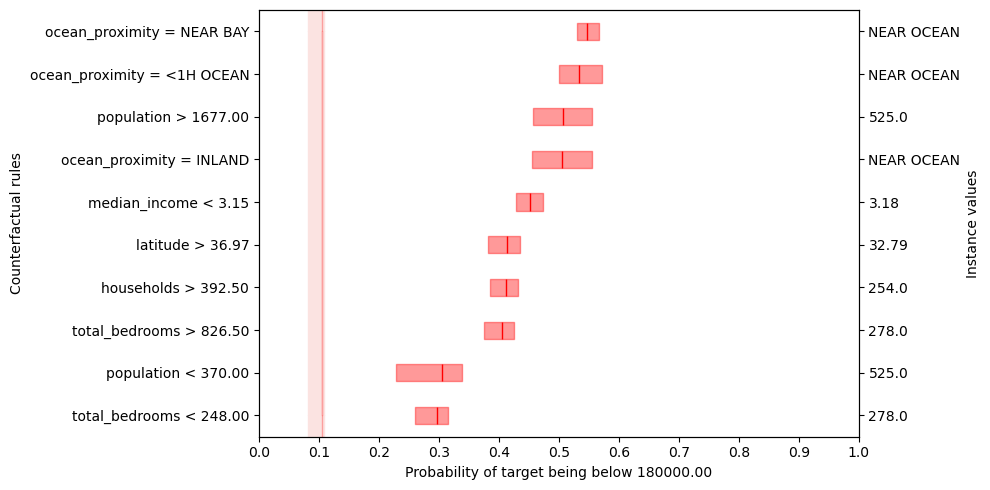

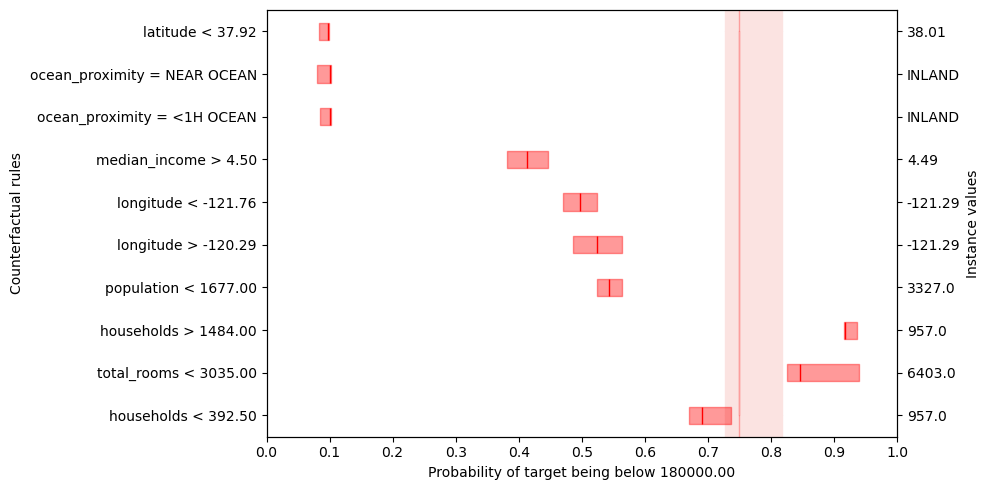

In [26]:
counterfactual_explanation.remove_conjunctions().plot()